In [20]:
# MN 21/10/23

# Pakiety
library(data.table)
library(magrittr)
library(ggplot2)
library(gridExtra)

library(knitr)
library(kableExtra)

# Oprócz tego korzystam httr, jsonlite oraz IRkernel do połaczenia z Jupyter

######################################################################
# Używam PostreSQL
library(RPostgreSQL)


# Parametry połączenia z serwerem PostgreSQL zmiennych środowiskowych
# Można zastąpić str
db_param <- list(
  user = Sys.getenv("DB_USER"),
  pass = Sys.getenv("DB_PASS"),
  base = Sys.getenv("DB_BASE"),
  host = Sys.getenv("DB_HOSTNAME")
)
drv <- dbDriver("PostgreSQL")
con <- dbConnect(
    drv, 
    user = db_param$user,
    password = db_param$pass, 
    dbname = db_param$base, host = db_param$host

)

# Który miesiąc max w 2023
MAX_23 <- 7

GetQuery <- function(x) dbGetQuery(con, x) %>% setDT()

######################################################################
# Ustawienia wyświetlania dla ggplot
theme_set(theme_bw())  
theme_update(legend.position="bottom", text = element_text(size = 20))
# Kolory: https://www.datanovia.com/en/blog/ggplot-colors-best-tricks-you-will-love/
# The palette with grey:
cbp1 <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
color_fill <- scale_fill_manual(values = cbp1)
# To use for line and point colors, add
color_color <- scale_colour_manual(values=cbp1)

options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.scale = 1.5)

# Dodatkowe funkcje
pperc <- function(x) sprintf("%1.1f%%", 100*x)

# Rendering tabeli
Table <- function(zbior, ...) {
    zbior %>%
    kable(...) %>%
    as.character() %>%
    IRdisplay::display_html()
}

# Deficyt planowany vs deficyt zrealizowany

In [21]:
######################################################################
# Obliczenia

lata <- 2015:2023

wydatki_po_cz <- lapply(lata, function(rok) {
    miesiac <- 12
    if (rok == 2023) miesiac <- MAX_23
    "
    select 
        rok,
        czesc,
        sum(wykonanie + wydatki_wygasle)/1e9 wyd_mld,
        sum(plan)/1e9 wyd_plan_mld
    from trezor.rb28 r 
    left join (
        select distinct on (id_dysp)
        id_dysp,
        id_dysp_nadrz,
        nazwa
        from trezor.slownik_dysponenci
        where date_part('year', to_date(aktywny_od, 'YYYY-MM-DD')) <= %1$s and 
        	(date_part('year', to_date(aktywny_do, 'YYYY-MM-DD')) >= %1$s or aktywny_do = '')
        order by id_dysp, aktywny_od desc
    ) sld
    on r.id_dysp = sld.id_dysp
    where rok = %1$s and miesiac = %2$s and id_dysp_nadrz = 1
    group by rok, czesc
    " %>% sprintf(rok, miesiac) %>% GetQuery()
}) %>% rbindlist()

wyd <- wydatki_po_cz[, .(wyd = sum(wyd_mld), wyd_plan = sum(wyd_plan_mld)), keyby = rok]

wyd %>%
    Table(
        "html", 
        caption = "Wydatki planowane/zrealizowane oraz deficyt, mld zł",
        digits = 3
    )

rok,wyd,wyd_plan
2015,331.743,336.680
2016,360.843,368.549
2017,375.768,384.774
2018,390.454,397.197
2019,414.272,416.235
2020,504.776,508.019
2021,521.217,523.493
2022,517.399,521.837
2023,337.103,672.544


In [22]:
# Dochody

dochody <- lapply(lata, function(rok) {
    miesiac <- 12
    if (rok == 2023) miesiac <- MAX_23
    "
    select 
        rok,
        sum(dochody_wykonane)/1e9 doch,
        sum(plan)/1e9 doch_plan
    from trezor.rb27 r 
    left join (
        select distinct on (id_dysp)
        id_dysp,
        id_dysp_nadrz,
        nazwa
        from trezor.slownik_dysponenci
        where date_part('year', to_date(aktywny_od, 'YYYY-MM-DD')) <= %1$s and 
        	(date_part('year', to_date(aktywny_do, 'YYYY-MM-DD')) >= %1$s or aktywny_do = '')
        order by id_dysp, aktywny_od desc
    ) sld
    on r.id_dysp = sld.id_dysp
    where rok = %1$s and miesiac = %2$s and id_dysp_nadrz = 1
    group by rok
    " %>% sprintf(rok, miesiac) %>% GetQuery()
}) %>% rbindlist()

dochody %>%
    Table(
        "html", 
        caption = "Dochody i wydatki planowane/zrealizowane oraz deficyt, mld zł",
        digits = 3
    ) 

rok,doch,doch_plan
2015,289.137,286.700
2016,314.684,313.809
2017,350.415,325.428
2018,380.048,355.705
2019,400.535,387.735
2020,419.796,398.672
2021,494.843,482.985
2022,504.821,491.937
2023,324.012,604.544


In [23]:
# Łącz
doch_wyd <- merge(
    wyd,
    dochody,
    all = TRUE,
    by = "rok"
)

doch_wyd[, deficyt_plan := doch_plan - wyd_plan]
doch_wyd[, deficyt_wyk := doch - wyd]
doch_wyd[, deficyt_roznica := deficyt_wyk - deficyt_plan]

doch_wyd %>%
    Table(
        "html", 
        caption = "Dochody i wydatki planowane/zrealizowane oraz deficyt, mld zł",
        digits = 3
    ) 

rok,wyd,wyd_plan,doch,doch_plan,deficyt_plan,deficyt_wyk,deficyt_roznica
2015,331.743,336.680,289.137,286.700,-49.980,-42.607,7.373
2016,360.843,368.549,314.684,313.809,-54.740,-46.160,8.580
2017,375.768,384.774,350.415,325.428,-59.345,-25.354,33.992
2018,390.454,397.197,380.048,355.705,-41.492,-10.406,31.086
2019,414.272,416.235,400.535,387.735,-28.500,-13.737,14.763
2020,504.776,508.019,419.796,398.672,-109.348,-84.980,24.367
2021,521.217,523.493,494.843,482.985,-40.508,-26.373,14.134
2022,517.399,521.837,504.821,491.937,-29.900,-12.578,17.322
2023,337.103,672.544,324.012,604.544,-68.000,-13.091,54.909


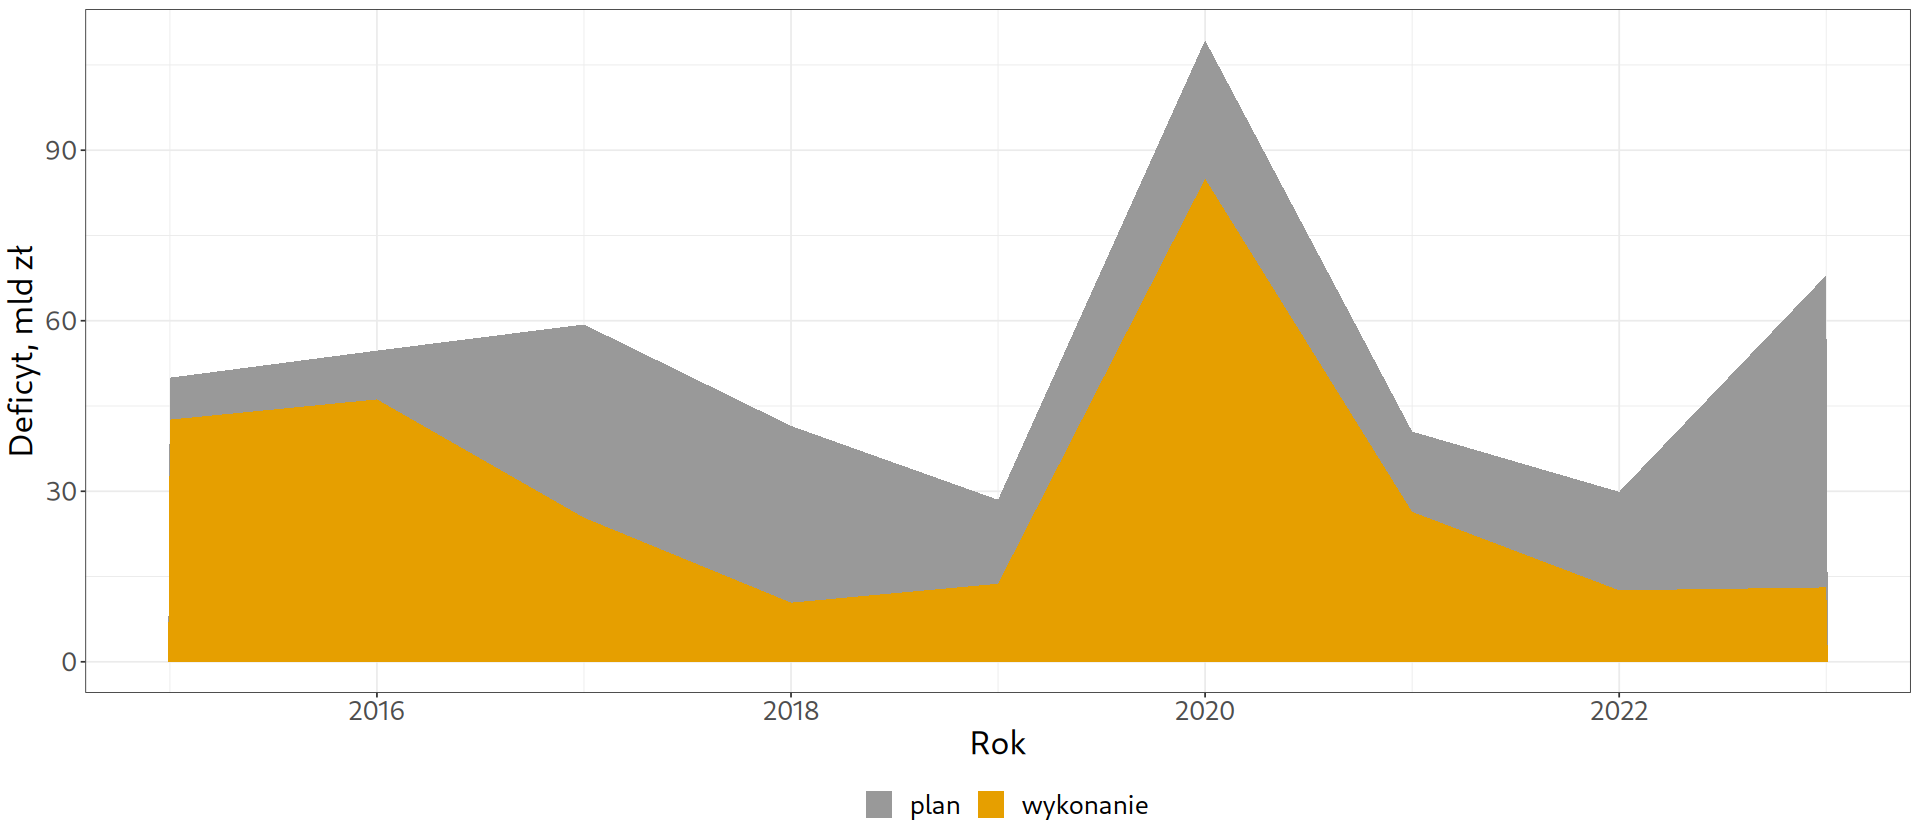

In [24]:
doch_wyd[, .(rok, plan = -deficyt_plan+deficyt_wyk, wykonanie = -deficyt_wyk)] %>%
    melt(id.vars = "rok") %>%
    ggplot(aes(x=rok, y = value, fill = variable)) + geom_area() + color_fill +
    labs(x = "Rok", y = "Deficyt, mld zł", fill = "")

# Deficyt wg wersji UB

In [25]:
wyd_plany <- "SELECT
rok,
sum(case when wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 rds,
sum(case when wersja = 'Rządowy projekt ustawy budżetowej' then kwota else 0 end) / 1e6 projekt,
sum(case when wersja = 'Ustawa budżetowa' then kwota else 0 end) / 1e6 ustawa,
sum(case when wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 nowela
FROM trezor.ub_wydatki
GROUP BY rok
" %>% GetQuery() %>% 
    merge(
        doch_wyd[, .(rok, wykonane = wyd)],
        all.x = TRUE,
        by = "rok"
    )

wyd_plany %>%
    Table(
        "html", 
        caption = "Wydatki planowane/zrealizowane, mld zł",
        digits = 3
    ) 

rok,rds,projekt,ustawa,nowela,wykonane
2016,351.499,368.529,368.549,0.000,360.843
2017,383.400,384.774,384.774,384.774,375.768
2018,397.209,397.195,397.197,0.000,390.454
2019,415.415,416.112,416.235,0.000,414.272
2020,429.480,435.340,435.340,508.019,504.776
2021,486.028,486.741,486.784,523.493,521.217
2022,505.635,512.362,521.837,0.000,517.399
2023,669.431,672.691,672.544,693.378,337.103
2024,848.342,0.000,0.000,0.000,NA


In [26]:
doch_plany <- "SELECT
rok,
sum(case when wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 rds,
sum(case when wersja = 'Rządowy projekt ustawy budżetowej' then kwota else 0 end) / 1e6 projekt,
sum(case when wersja = 'Ustawa budżetowa' then kwota else 0 end) / 1e6 ustawa,
sum(case when wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 nowela
FROM trezor.ub_dochody
GROUP BY rok
" %>% GetQuery() %>% 
    merge(
        doch_wyd[, .(rok, wykonane = doch)],
        all.x = TRUE,
        by = "rok"
    )

doch_plany %>%
    Table(
        "html", 
        caption = "Dochody planowane/zrealizowane, mld zł",
        digits = 3
    )

rok,rds,projekt,ustawa,nowela,wykonane
2016,296.879,313.789,313.809,0.000,314.684
2017,324.055,325.426,325.428,0.000,350.415
2018,355.717,355.703,355.705,0.000,380.048
2019,386.915,387.612,387.735,0.000,400.535
2020,429.480,435.340,435.340,398.672,419.796
2021,403.728,404.441,404.484,482.985,494.843
2022,475.625,481.437,491.937,0.000,504.821
2023,604.431,604.691,604.544,601.378,324.012
2024,683.572,0.000,0.000,0.000,NA


In [27]:
plany <- merge(
    wyd_plany %>% melt(id.vars = "rok", value.name = "wyd"),
    doch_plany %>% melt(id.vars = "rok", value.name = "doch"),
    all = TRUE,
    by = c("rok", "variable")
)

plany[doch != 0 & wyd != 0, deficyt := doch - wyd]

plany %>% dcast(rok ~ variable, value.var = "deficyt") %>%
    Table(
        "html", 
        caption = "Deficyt wg planów oraz wykonany, mld zł",
        digits = 3
    )

rok,rds,projekt,ustawa,nowela,wykonane
2016,-54.620,-54.740,-54.740,NA,-46.160
2017,-59.346,-59.347,-59.346,NA,-25.354
2018,-41.492,-41.492,-41.492,NA,-10.406
2019,-28.500,-28.500,-28.500,NA,-13.737
2020,0.000,0.000,0.000,-109.348,-84.980
2021,-82.300,-82.300,-82.300,-40.508,-26.373
2022,-30.010,-30.925,-29.900,NA,-12.578
2023,-65.000,-68.000,-68.000,-92.000,-13.091
2024,-164.770,NA,NA,NA,NA


# Plan wydatków na 2024 vs nowela 2023

In [28]:
wyd_23_24 <- "SELECT
rok,
czesc,
sum(kwota)/1e6 as wyd_mld
FROM trezor.ub_wydatki
WHERE (rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego') or (rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej')
GROUP BY rok, czesc
" %>% GetQuery()

slownik_cz <- "
SELECT czesc, opis
FROM trezor.slownik_czesci
where date_part('year', to_date(aktywny_od, 'YYYY-MM-DD')) <= 2023 and 
        	(date_part('year', to_date(aktywny_do, 'YYYY-MM-DD')) >= 2023 or aktywny_do = '')
" %>% GetQuery()

wyd_23_24 <- wyd_23_24 %>% dcast(czesc ~ rok, value.var = "wyd_mld")

wyd_23_24 <- merge(
    wyd_23_24,
    slownik_cz,
    all.x=TRUE
)

wyd_23_24[, prop_24_23 := `2024` / `2023`]
wyd_23_24[, diff_24_23 := `2024` - `2023`]
wyd_23_24[
    order(-diff_24_23),    .(
        czesc, opis,
        `2023`, `2024`, 
        `Różnica` = diff_24_23,
        `Wzrost r/r` = pperc(prop_24_23-1)
    )][1:10] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 wg części, mld zł",
        digits = 3
    )

czesc,opis,2023,2024,Różnica,Wzrost r/r
73,Zakład Ubezpieczeń Społecznych,114.358,190.559,76.201,66.6%
29,Obrona narodowa,97.125,112.733,15.609,16.1%
46,Zdrowie,14.192,26.716,12.524,88.2%
83,Rezerwy celowe,65.445,75.751,10.306,15.7%
72,Kasa Rolniczego Ubezpieczenia Społecznego,20.141,27.428,7.286,36.2%
42,Sprawy wewnętrzne,32.114,39.329,7.215,22.5%
79,Obsługa długu Skarbu Państwa,62.000,68.500,6.500,10.5%
82,Subwencje ogólne dla jednostek samorządu terytorialnego,99.638,103.328,3.690,3.7%
19,"Budżet, finanse publiczne i instytucje finansowe",9.882,13.053,3.171,32.1%
84,Środki własne Unii Europejskiej,33.073,35.180,2.108,6.4%


In [29]:
slownik_rozdzial <- "
SELECT rozdzial, opis
FROM trezor.slownik_rozdzialy
where date_part('year', to_date(aktywny_od, 'YYYY-MM-DD')) <= 2023 and 
        	(date_part('year', to_date(aktywny_do, 'YYYY-MM-DD')) >= 2023 or aktywny_do = '')
" %>% GetQuery()

slownik_grupa <- "
SELECT nr_grupy, opis
FROM trezor.slownik_grupy_ekonomiczne
where date_part('year', to_date(aktywny_od, 'YYYY-MM-DD')) <= 2023 and 
        	(date_part('year', to_date(aktywny_do, 'YYYY-MM-DD')) >= 2023 or aktywny_do = '')
" %>% GetQuery()

In [30]:
slownik_grupa

nr_grupy,opis
<chr>,<chr>
1,"Wydatki na realizację programów finansowanych z udziałem środków, o których mowa w art. 5 ust. 1 pkt 2 ustawy, w tym wydatki budżetu środków europejskich"
2,Dotacje i subwencje
3,Świadczenia na rzecz osób fizycznych
4,Wydatki bieżące jednostek budżetowych
6,Wydatki majątkowe
8,Obsługa długu publicznego
9,Środki własne Unii Europejskiej


In [53]:
roz <- "SELECT
rozdzial, grupa_ekon, 

sum(case when rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 ub_23_nowela,
sum(case when rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 ub_24_rds

FROM trezor.ub_wydatki
group by rozdzial, grupa_ekon
" %>% GetQuery()


roz <- merge(
    roz,
    slownik_rozdzial,
    all.x = TRUE
)

roz[
    order(-(ub_24_rds - ub_23_nowela)), 
    .(
        rozdzial, opis, `Grupa` = grupa_ekon, `2023` = ub_23_nowela, `2024` = ub_24_rds, 
        `Różnica` = ub_24_rds - ub_23_nowela,
        `Proporcja różnicy` = pperc((ub_24_rds - ub_23_nowela) / sum(ub_24_rds - ub_23_nowela))
    )
][1:10] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 wg rozdziałów, mld zł",
        digits = 3
    )

rozdzial,opis,Grupa,2023,2024,Różnica,Proporcja różnicy
75313,Świadczenia finansowane z budżetu państwa zlecone do wypłaty Zakładowi Ubezpieczeń Społecznych i Kasie Rolniczego Ubezpieczenia Społecznego,3,4.236,33.546,29.309,18.9%
75303,Fundusz Ubezpieczeń Społecznych,2,59.752,84.266,24.513,15.8%
85501,Świadczenie wychowawcze,3,40.154,63.655,23.501,15.2%
75818,Rezerwy ogólne i celowe,2,23.651,41.183,17.532,11.3%
75801,Część oświatowa subwencji ogólnej dla jednostek samorządu terytorialnego,2,64.581,76.608,12.028,7.8%
75204,Centralne wsparcie,6,27.323,37.805,10.482,6.8%
85195,Pozostała działalność,2,4.410,13.599,9.189,5.9%
75301,Świadczenia pieniężne z zaopatrzenia emerytalnego,3,25.390,32.335,6.945,4.5%
75703,"Obsługa zadłużenia, należności i innych operacji finansowych Skarbu Państwa na rynku krajowym",8,54.730,59.844,5.114,3.3%
75305,Fundusz Emerytalno-Rentowy,2,19.878,24.159,4.281,2.8%


In [32]:
roz <- "SELECT
rozdzial, grupa_ekon, 

sum(case when rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 ub_23_nowela,
sum(case when rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 ub_24_rds

FROM trezor.ub_wydatki
where czesc = '73'
group by rozdzial, grupa_ekon
" %>% GetQuery()


roz <- merge(
    roz,
    slownik_rozdzial,
    all.x = TRUE
)

roz[
    order(-(ub_24_rds - ub_23_nowela)), 
    .(
        `Rodział` = rozdzial, opis, `Grupa` = grupa_ekon, 
        `2023` = ub_23_nowela, `2024` = ub_24_rds, `Różnica` = ub_24_rds - ub_23_nowela
    )][1:5] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 dla cz. 73 wg rozdziałów, mld zł",
        digits = 3
    )

Rodział,opis,Grupa,2023,2024,Różnica
75313,Świadczenia finansowane z budżetu państwa zlecone do wypłaty Zakładowi Ubezpieczeń Społecznych i Kasie Rolniczego Ubezpieczenia Społecznego,3,4.000,30.321,26.321
75303,Fundusz Ubezpieczeń Społecznych,2,59.752,84.266,24.513
85501,Świadczenie wychowawcze,3,40.154,63.655,23.501
85595,Pozostała działalność,3,0.000,0.950,0.950
75310,Fundusz Emerytur Pomostowych,2,1.843,2.599,0.757


In [33]:
roz <- "SELECT
rozdzial, grupa_ekon, 

sum(case when rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 ub_23_nowela,
sum(case when rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 ub_24_rds

FROM trezor.ub_wydatki
where czesc = '29'
group by rozdzial, grupa_ekon
" %>% GetQuery()


roz <- merge(
    roz,
    slownik_rozdzial,
    all.x = TRUE
)

roz[
    order(-(ub_24_rds - ub_23_nowela)), 
    .(
        `Rodział` = rozdzial, opis, `Grupa` = grupa_ekon, 
        `2023` = ub_23_nowela, `2024` = ub_24_rds, `Różnica` = ub_24_rds - ub_23_nowela
    )][1:5] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 dla cz. 29 wg rozdziałów, mld zł",
        digits = 3
    )

Rodział,opis,Grupa,2023,2024,Różnica
75204,Centralne wsparcie,6,27.323,37.805,10.482
75204,Centralne wsparcie,4,6.666,10.525,3.858
75301,Świadczenia pieniężne z zaopatrzenia emerytalnego,3,9.501,11.114,1.614
75201,Wojska Lądowe,4,5.535,6.615,1.080
75222,Agencja Mienia Wojskowego,6,0.250,0.588,0.338


In [34]:
roz <- "SELECT
rozdzial, grupa_ekon, 

sum(case when rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 ub_23_nowela,
sum(case when rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 ub_24_rds

FROM trezor.ub_wydatki
where czesc = '46'
group by rozdzial, grupa_ekon
" %>% GetQuery()


roz <- merge(
    roz,
    slownik_rozdzial,
    all.x = TRUE
)

roz[
    order(-(ub_24_rds - ub_23_nowela)), 
    .(
        `Rodział` = rozdzial, opis, `Grupa` = grupa_ekon, 
        `2023` = ub_23_nowela, `2024` = ub_24_rds, `Różnica` = ub_24_rds - ub_23_nowela
    )][1:5] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 dla cz. 46 wg rozdziałów, mld zł",
        digits = 3
    )

Rodział,opis,Grupa,2023,2024,Różnica
85195,Pozostała działalność,2,4.280,13.587,9.307
85157,Staże i specjalizacje medyczne,4,3.700,5.786,2.086
85112,Szpitale kliniczne,6,0.970,1.414,0.445
73014,Działalność dydaktyczna i badawcza,2,2.085,2.433,0.348
73014,Działalność dydaktyczna i badawcza,6,0.148,0.332,0.184


In [35]:
roz <- "SELECT
rozdzial, grupa_ekon, 

sum(case when rok = 2023 and wersja = 'Nowelizacja Ustawy budżetowej' then kwota else 0 end) / 1e6 ub_23_nowela,
sum(case when rok = 2024 and wersja = 'Projekt ustawy budżetowej – Rada dialogu społecznego' then kwota else 0 end) / 1e6 ub_24_rds

FROM trezor.ub_wydatki
where czesc = '72'
group by rozdzial, grupa_ekon
" %>% GetQuery()


roz <- merge(
    roz,
    slownik_rozdzial,
    all.x = TRUE
)

roz[
    order(-(ub_24_rds - ub_23_nowela)), 
    .(
        `Rodział` = rozdzial, opis, `Grupa` = grupa_ekon, 
        `2023` = ub_23_nowela, `2024` = ub_24_rds, `Różnica` = ub_24_rds - ub_23_nowela
    )][1:5] %>%
    Table(
        "html", 
        caption = "Największe różnice między NUB2023 a UB2024 dla cz. 72 wg rozdziałów, mld zł",
        digits = 3
    )

Rodział,opis,Grupa,2023,2024,Różnica
75305,Fundusz Emerytalno-Rentowy,2,19.878,24.159,4.281
75313,Świadczenia finansowane z budżetu państwa zlecone do wypłaty Zakładowi Ubezpieczeń Społecznych i Kasie Rolniczego Ubezpieczenia Społecznego,3,0.236,3.225,2.989
75313,Świadczenia finansowane z budżetu państwa zlecone do wypłaty Zakładowi Ubezpieczeń Społecznych i Kasie Rolniczego Ubezpieczenia Społecznego,2,0.006,0.024,0.019
75306,Fundusz Prewencji i Rehabilitacji,2,0.014,0.019,0.006
85335,Refundacja ulg dla inwalidów wojennych i wojskowych z tytułu ubezpieczenia OC i AC,3,0.000,0.000,0.000
